Given link flows and capacity constraints, this function finds a feasible set of link flows. The inputs to the function are:

f(vector): given (possibly infeasible) link flows

u(vector): link capacity constraints to be met

delta(matrix): link*route incidence matrix

od2route(matrix): K*max_r gives indices of all routes for a given od pair

The output of the function is 

f_feas(vector): feasible link flows for given capacity constraints

In [1]:
debug = False
def find_feasible(f,u,delta,od2route):
    import numpy as np
    delta = np.matrix(delta)
    u = np.array(u)
    
    l = np.shape(f)[0] #number of links in network
    K = np.shape(od2route)[0] #number of od pairs in network
    r = np.shape(delta)[1] #number of routes in network
    d = np.zeros((l,r))
    f_feas = f #vector of feasible flows satisfying capacity constraints
    for k in range(K):
        if debug:
            print('OD pair: %d'%(k+1))
        r_k = od2route[k,:] #vector of indices of all routes bw od pair k
        if isinstance(r_k,list): 
            r_k = r_k[0]
        r_k = r_k[np.invert(np.isnan(r_k))] #take only existing routes
        r_k = r_k.astype(int)
        if debug:
            print('Routes %s'%r_k)
        flag1 = [f_feas>u] 
        sat_f = np.nonzero(flag1)[1] #indices of saturated flows
        d = (delta>0) #binary link route incidence matrix
        d = d*1
        #update the incidence matrix to find saturated flows
    
        # for R in r_k:
        for i in sat_f:
            d[i,:] = 2 * d[i,:]
        #        if d[i,R]>0:
        #            d[i,R] = d[i,R]+1 #matrix indicating routes with saturated links
                    #0: link not in route, 1: unsaturated link, 2: saturated link
        sat = np.where(np.max(d[:,r_k],axis=0)==2)[1] #saturated routes
        unsat = np.where(np.max(d[:,r_k],axis=0)==1)[1] #unsaturated routes
        if np.size(sat)==0 and debug:#if no saturated route is present for a given od pair
            print('No saturated route for OD pair: %d'%(k+1))
        
        else:#presence of at least one saturated route
            f_r = 1.0
            for r in sat:#For each saturated route
                if (np.max(d[:,r],axis=0)==2)&(f_r>0):
                    l_r = np.where(d[:,r]>0)[0] #links in saturated route r
                    f_r = max(f_feas[l_r]-u[l_r]) #flow to be rerouted from saturated route r
                    flag = 1
                    while flag: # as long as the route r remains saturated
                        unsat = np.where(np.max(d[:,r_k],axis=0)==1)[1] #unsaturated routes
                        cap = np.zeros(np.size(unsat))
                        c = 0
                        for us in unsat: #compute extra capacity for unsaturated routes
                            l_u = np.where(d[:,us]>0)[0] #links in unsaturated route u
                            cap[c] = min(u[l_u]-f_feas[l_u]) #extra capacity of unsaturated route u
                            c = c+1
                        i_unsat_sort = np.flip(np.argsort(cap),0) #unsaturated routes sorted in decreasing order of capacities
                        cap_sort = cap[i_unsat_sort] 
                        if f_r<=cap_sort[0]: #all flow to be rerouted can be put in one unsat route
                            f_feas[np.where(d[:,r]>0)[0]] = f_feas[np.where(d[:,r]>0)[0]]-f_r #remove f_r from sat route r
                            f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]] = f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]]+f_r #move f_r to route with highest capacity
                            gl = np.where(d[:,r]==2)[0]
                            d[np.where(d[:,r]>0)[0],r] = 1
                            d[gl,np.where(d[gl,:]>0)[1]] = 1
                            flag = 0
                        else: #split flow to be rerouted
                            f_feas[np.where(d[:,r]>0)[0]] = f_feas[np.where(d[:,r]>0)[0]]-cap_sort[0] #remove cap_sort[0] from sat route r
                            f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]] = f_feas[np.where(d[:,unsat[i_unsat_sort[0]]]>0)[0]]+cap_sort[0] #move f_r to route with highest capacity
                            f_r = f_r-cap_sort[0]
                            flag = 1
    if debug:
        print('Capacities:')
        print(u)
        print('Feasible flows:')
        print(f_feas)
    return f_feas

In [2]:
import numpy as np
f = np.matrix([3.5,1,2.5,1,3.5])
f = f.reshape((5,1))
u = np.matrix([10.0,10.0,2.0,10.0,10.0])
u = u.reshape((5,1))
delta = np.matrix([[1,1,0],[0,0,1],[0,1,0],[1,0,0],[0,1,1]])
od2route = np.array([[0,1,2]])

In [3]:
f_feas = find_feasible(f,u,delta,od2route)

In [4]:
import numpy as np
f = np.matrix([4.0,2.0,3.0,1.0,5.0])
f = f.reshape((5,1))
u = np.matrix([10.0,10.0,2.0,10.0,10.0])
u = u.reshape((5,1))
delta = np.matrix([[1,1,0,1,0],[0,0,1,0,1],[0,1,0,1,0],[1,0,0,0,0],[0,1,1,0,0]])
od2route = np.array([[0,1,2],[3,4,np.nan]])
f_feas = find_feasible(f,u,delta,od2route)

In [5]:
def inv_route_to_od(route2od):
    nb_od = np.max(route2od) + 1
    od2route = {}
    nb_path_max_od_tmp = np.zeros(nb_od, dtype=int)
    for i in range(len(route2od)):
        if route2od[i] not in od2route.keys():
            od2route[route2od[i]] = set()
        od2route[route2od[i]].add(i)
        nb_path_max_od_tmp[route2od[i]] += 1

    nb_path_max_od = np.max(nb_path_max_od_tmp)
    od2route_tmp = np.ones((nb_od, nb_path_max_od)) * np.nan
    for i in od2route.keys():
        for j in range(len(od2route[i])):
            od2route_tmp[i][j] = od2route[i].pop()
    return od2route_tmp

In [11]:
import Frank_Wolf_solver
import lower_bound
I210 = 'data/I210'
Chic = 'data/Chicago'
Anah = 'data/Anaheim'
Siou = 'data/SiouxFalls'
Brae = 'data/braess'

network_name = Brae
graph, demand = Frank_Wolf_solver.load_network(network_name)

eps=1e-8
nb_iter = 1000

nb_point = 12
obj_feas = np.zeros(nb_point)
obj_sol = np.zeros(nb_point)
cap_array = np.zeros(nb_point)
var_dual = np.zeros(nb_point)

u_old = [11,11,11,11,11]
if network_name == Brae:
    demand[0][2] = 10
path_flow_matrix_old, tt_f_old, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u_old)
f_old = delta.T @ path_flow_matrix_old
    
for cap_tmp in range(nb_point):
    cap = (12 - (cap_tmp))/2
    c = -1
    if network_name == Brae:
        demand[0][2] = 10
        u = [11, 11, cap, 11, 11]

    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, c)
    delta = delta.T
    f = delta @ path_flow_matrix
    od2route = inv_route_to_od(route2od)

    f_feas = find_feasible(f,u,delta,od2route)
    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u)
    delta = delta.T
    f_sol = delta @ path_flow_matrix
    
    
    if debug:
        print("++++ TEST ++++")
        print(f_old)
        print(u)
        print((f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1))
    var_dual[cap_tmp], dual_vars, _ = lower_bound.lower_bound(f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1)
    obj_feas[cap_tmp] = Frank_Wolf_solver.potential(graph, f_feas)
    obj_sol[cap_tmp] = Frank_Wolf_solver.potential(graph, f_sol)
    cap_array[cap_tmp] = cap
    
    #f_old = f_sol
    #path_flow_matrix_old = path_flow_matrix
    #tt_f_old = tt_f
    #u_old = u
    print()
    print(cap)
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Objective dual: " + str(var_dual[cap_tmp]))
    
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))
    
if debug:
    print()
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))



6.0
Comparing the solutions:
Objective solution: 31.87501072025814
Objective estimate: 31.875003701876892
Objective dual: -0.007325034588120479
Link flow solution: [7.51362818 2.48637182 5.01898335 2.49464483 7.50535517]
Link flow feasible flow: [7.49925207 2.50074793 5.00782401 2.49142806 7.50857194]
Path flow solution: [5.01898335 2.49464483 2.48637182]
Path flow feasible flow: [5.00782401 2.49142806 2.50074793]

5.5
Comparing the solutions:
Objective solution: 31.8750003260696
Objective estimate: 31.875003701876892
Objective dual: -0.007312250036795123
Link flow solution: [7.49820088 2.50179912 5.00001322 2.49818766 7.50181234]
Link flow feasible flow: [7.49925207 2.50074793 5.00782401 2.49142806 7.50857194]
Path flow solution: [5.00001322 2.49818766 2.50179912]
Path flow feasible flow: [5.00782401 2.49142806 2.50074793]

5.0
Comparing the solutions:
Objective solution: 31.875000738291135
Objective estimate: 31.875000055939694
Objective dual: -0.0072980179065558395
Link flow soluti

In [12]:
import matplotlib.pyplot as plt

[-0.00732503 -0.00731225 -0.00729802 -0.00728209 -0.00726416 -0.00724394
 -0.00722114 -0.0071956  -0.00718398 -0.00718427 -0.00719304 -0.00721381]
[31.87501072 31.86769847 31.86770231 31.86771865 31.87398608 31.89275694
 31.92403287 31.96780446 32.02406606 32.09281667 32.17405696 32.26778692]
[31.87501072 31.87500033 31.87500074 31.88125025 31.90000088 31.93125401
 31.97500006 32.03125003 32.10000094 32.18125    32.27500073 32.38125079]


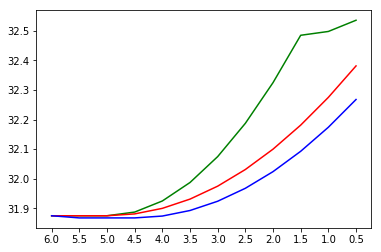

In [13]:
print(var_dual)
obj_dual = np.zeros(nb_point)
for i in range(len(var_dual)):
    obj_dual[0] = obj_sol[0]
    if i != 0:
        obj_dual[i] = obj_sol[i-1] + var_dual[i]
# print(obj_dual)
# print(obj_sol)

plt.plot(cap_array[::-1], obj_feas, color='green')
plt.plot(cap_array[::-1], obj_sol, color='red')
plt.plot(cap_array[::-1], obj_dual, color='blue')
plt.xticks(cap_array, cap_array[::-1])
plt.show()

In [9]:
print(var_dual)
obj_dual = np.zeros(nb_point)
for i in range(len(var_dual)):
    obj_dual[0] = obj_sol[0]
    if i != 0:
        obj_dual[i] = obj_sol[i-1] + var_dual[i]
print(obj_dual)
print(obj_sol)

[-0.00732503 -0.00729802 -0.00729802 -0.00726416 -0.00726416 -0.00722114
 -0.00722114 -0.00718398 -0.00718398 -0.00719304 -0.00719304         inf]
[31.87501072 31.8677127  31.86770272 31.86773658 31.89273672 31.89277975
 31.96777893 31.96781609 32.09281697 32.0928079  32.26780769         inf]
[31.87501072 31.87500074 31.87500074 31.90000088 31.90000088 31.97500006
 31.97500006 32.10000094 32.10000094 32.27500073 32.27500073 32.5       ]


In [ ]:
I210 = 'data/I210'
Chic = 'data/Chicago'
Anah = 'data/Anaheim'
Siou = 'data/SiouxFalls'
Siou2 = 'data/SiouxFalls_bis'
Brae = 'data/braess'

network_name = Siou2
eps=1e-8
nb_iter = 1000
graph, demand = Frank_Wolf_solver.load_network(network_name)

u_old = np.ones(int(np.max(graph[:,0])+1))
u_old = u_old * 50000
u_old[27] = 20000
u_old[42] = 20000

path_flow_matrix_old, tt_f_old, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u_old)
f_old = delta.T @ path_flow_matrix_old


nb_point = 12
obj_feas = np.zeros(nb_point)
obj_sol = np.zeros(nb_point)
cap_array = np.zeros(nb_point)
var_dual = np.zeros(nb_point)

file = open("results.txt", "w")

for cap_tmp in range(nb_point):
    cap = (nb_point - (cap_tmp))/nb_point * u_old[27]
    c = -1
    u = u_old.copy()
    u[27] = cap
    u[24] = cap

    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, c)
    delta = delta.T
    f = delta @ path_flow_matrix
    od2route = inv_route_to_od(route2od)

    f_feas = find_feasible(f,u,delta,od2route)
    path_flow_matrix, tt_f, delta, route2od = Frank_Wolf_solver.Frank_Wolf_solver(graph, demand, eps, nb_iter, u)
    delta = delta.T
    f_sol = delta @ path_flow_matrix
    
    file.write(str(cap) + ", flow sol, " + str(f_sol) + "\n")
    if debug:
        print("++++ TEST ++++")
        print(u_old)
        print(u)
        print((f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1))
        var_dual[cap_tmp], dual_vars, _ = lower_bound.lower_bound(f_old, path_flow_matrix_old, tt_f_old, delta.T, route2od, np.array(f_old), np.array(u), 1)
    
    
    obj_feas[cap_tmp] = Frank_Wolf_solver.potential(graph, f_feas)
    obj_sol[cap_tmp] = Frank_Wolf_solver.potential(graph, f_sol)
    cap_array[cap_tmp] = cap
    
    file.write(str(cap) + ", flow upperbound, " + str(f_feas) + "\n")
    
    #f_old = f_sol
    #path_flow_matrix_old = path_flow_matrix
    #tt_f_old = tt_f
    #u_old = u
    print()
    print(cap)
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Objective dual: " + str(var_dual[cap_tmp]))
    
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))
    
if debug:
    print()
    print("Comparing the solutions:")
    print("Objective solution: " + str(Frank_Wolf_solver.potential(graph, f_sol)))
    print("Objective estimate: " + str(Frank_Wolf_solver.potential(graph, f_feas)))
    print("Link flow solution: " + str(f_sol))
    print("Link flow feasible flow: " + str(f_feas))
    print("Path flow solution: " + str(path_flow_matrix))
    print("Path flow feasible flow: " + str(np.linalg.pinv(delta) @ f_feas))

file.close()


20000.0
Comparing the solutions:
Objective solution: 5110228.668702572
Objective estimate: 4187162.9482888803
Objective dual: 0.0
Link flow solution: [ 4315.08626998  9401.14217431  5874.47001878  6426.09943439
  6016.94364456 14246.97723408 13193.58284959 12308.09510984
 19592.559702    9252.03388616 19836.57094659  8943.13814031
 15399.69862263  6504.19022635  8901.30374349 13942.55789331
 14849.79846731 18267.80847196 13978.81428846 15501.28429219
  8323.08479676  9276.21124673 15783.74150905  8853.38742161
 19999.89882376 21059.73744757 18178.73729231 19999.98890967
 12786.56233755  9833.17045224  7293.22177665 20172.39630166
  8814.49713888 11306.67079919 11848.26644408  9298.06043558
 14897.84255081 14136.089442   12319.62105538 11082.03566164
  9380.33839169  8806.2271859  19581.97683178  9250.39464942
 19979.64140269 19217.30228698  9485.64211304 12508.25371857
 13971.39032901 19042.33367898 10333.95285617 13542.82573214
 12500.46313132 17648.81719154 19434.51506764 21457.2800

In [ ]:
print(var_dual)
obj_dual = np.zeros(nb_point)
for i in range(len(var_dual)):
    obj_dual[0] = obj_sol[0]
    if i != 0:
        obj_dual[i] = obj_sol[i-1] + var_dual[i]
print(obj_dual)
print(obj_sol)

In [ ]:
plt.plot(cap_array[::-1], obj_feas, color='green')
plt.plot(cap_array[::-1], obj_sol, color='red')
plt.plot(cap_array[::-1], obj_dual, color='blue')
plt.xticks(cap_array, cap_array[::-1])
plt.show()